In [53]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import scipy.signal as signal
import numpy as np


In [54]:
# CONSTANTS:
FILE_PREFIX = 'test_signal_'
FILE_SUFFIX = '.dat'
SAMPLING_FREQUENCY = 22 * 1_000  # 10 kHz
NUM_SAMPLES = SAMPLING_FREQUENCY  # 100 samples
MIN_INTENSITY = 0  # 0 intensity
MAX_INTENSITY = 65535  # 1 intensity
CUTOFF_FREQUENCY = 2000  # 2 kHz


In [55]:
def butterworth_filter(signal_data, cutoff_freq=2000, sampling_rate=10000, order=2):
    b, a = signal.butter(order, cutoff_freq, btype='low',
                         output='ba', fs=sampling_rate)
    # print(b[0], b[1], b[2], a[0], a[1], a[2])
    filtered_signal = signal.lfilter(b, a, signal_data)
    return filtered_signal


In [56]:
def test_coefficients(signal_data):
    b = [0.66388127470662783302657317108242,
         1.32776254941325566605314634216484, 0.66388127470662783302657317108242]
    a = [1, -1.25915639319533800843942117353436,
         0.39636870563117321264456904827966]
    
    filtered_signal = signal.lfilter(b, a, signal_data)
    return filtered_signal


In [57]:
# Read in impulse signal
impulse_signal = np.fromfile(
    FILE_PREFIX + 'impulse' + FILE_SUFFIX, dtype=np.uint16, sep='\n')

######## CHANGE THIS TO TEST DIFFERENT FILES ########
# Filtered Data to be analyzed:
# filtered_signal = np.fromfile('../test_files/test_signal_impulse_filtered.dat', dtype=np.uint16, sep='\n')
filtered_signal = np.fromfile('../removeme.dat', dtype=np.uint16, sep='\n')

# Apply low-pass filter to the impulse signal
filtered_impulse_signal = butterworth_filter(
    impulse_signal, cutoff_freq=CUTOFF_FREQUENCY, sampling_rate=SAMPLING_FREQUENCY, order=2)

# Calculate the FFT of the impulse signal: (Divide by max intensity to normalize)
impulse_fft = fft(impulse_signal) / MAX_INTENSITY
filtered_impulse_fft = fft(filtered_impulse_signal) / MAX_INTENSITY
filtered_signal_fft = fft(filtered_signal) / MAX_INTENSITY

# Calculate frequency values to plot
frequencies_impulse = np.linspace(0, impulse_signal.size *
                                  SAMPLING_FREQUENCY / NUM_SAMPLES / 2, impulse_signal.size // 2)

frequencies_filtered_impulse = np.linspace(0, filtered_impulse_signal.size *
                                           SAMPLING_FREQUENCY / NUM_SAMPLES / 2, filtered_impulse_signal.size // 2)

freq_filt = np.linspace(0, filtered_signal.size *
                        SAMPLING_FREQUENCY / NUM_SAMPLES / 2, filtered_signal.size // 2)

# Calculate the amplitude values to plot
amplitudes_impulse = np.abs(impulse_fft)[:impulse_signal.size // 2]
amplitudes_filtered_impulse = np.abs(filtered_impulse_fft)[
    :filtered_impulse_signal.size // 2]
amp_filt = np.abs(filtered_signal_fft)[:filtered_signal.size // 2]

# Calculate the Decibel change of the impulse signal at the cutoff frequency
# First find the frequency closest to the cutoff frequency
closest_frequency_index = np.abs(
    frequencies_filtered_impulse - CUTOFF_FREQUENCY).argmin()

decibel_change_scipy = 20 * \
    np.log10(amplitudes_filtered_impulse[closest_frequency_index] /
             amplitudes_impulse[closest_frequency_index])

decibel_change_filt = 20 * \
    np.log10(amp_filt[closest_frequency_index] /
             amplitudes_impulse[closest_frequency_index])


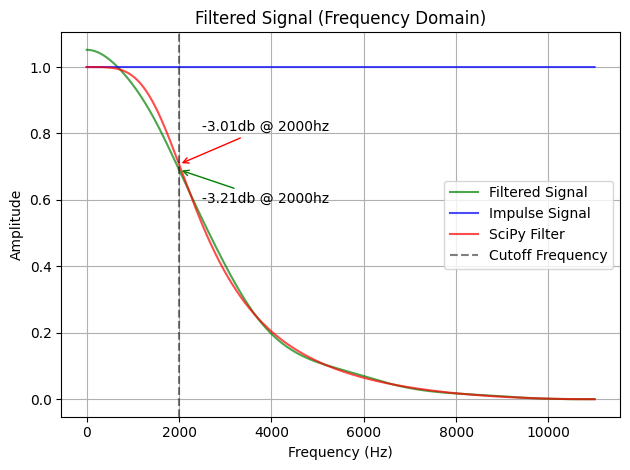

In [58]:
plt.plot(freq_filt, amp_filt,
         label='Filtered Signal', color='green', alpha=0.7)
plt.plot(frequencies_impulse, amplitudes_impulse,
         label='Impulse Signal', color='blue', alpha=0.7)
plt.plot(frequencies_filtered_impulse, amplitudes_filtered_impulse,
         label='SciPy Filter', color='red', alpha=0.7)

plt.axvline(CUTOFF_FREQUENCY, color='black',
            linestyle='--', label='Cutoff Frequency', alpha=0.5)

plt.annotate(f'{decibel_change_scipy:0.2f}db @ {CUTOFF_FREQUENCY}hz', xy=(CUTOFF_FREQUENCY, amplitudes_filtered_impulse[closest_frequency_index]), xytext=(CUTOFF_FREQUENCY + 500, amplitudes_filtered_impulse[closest_frequency_index] + 0.1), arrowprops=dict(
    arrowstyle='->', connectionstyle='arc3', color='red'), fontsize=10)

plt.annotate(f'{decibel_change_filt:0.2f}db @ {CUTOFF_FREQUENCY}hz', xy=(CUTOFF_FREQUENCY, amp_filt[closest_frequency_index]), xytext=(CUTOFF_FREQUENCY + 500, amp_filt[closest_frequency_index] - 0.1), arrowprops=dict(
    arrowstyle='->', connectionstyle='arc3', color='green'), fontsize=10)

plt.title('Filtered Signal (Frequency Domain)')
# plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
